<a href="https://colab.research.google.com/github/ShendreAk/DeepLearningCNN/blob/main/GAN_Pytorch_Tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training Generative Adversarial Networks (GANs) in PyTorch



In [1]:
!pip install opendatasets --upgrade --quiet

In [2]:
import opendatasets as od

dataset_url = 'https://www.kaggle.com/splcher/animefacedataset'
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: shendreakshay
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/splcher/animefacedataset


100%|██████████| 395M/395M [00:10<00:00, 37.9MB/s]


In [3]:
import os

DATA_DIR = './animefacedataset'
print(os.listdir(DATA_DIR))

['images']


In [4]:
print(os.listdir(DATA_DIR+'/images')[:10])

['10787_2005.jpg', '11886_2005.jpg', '54908_2016.jpg', '3761_2002.jpg', '28184_2009.jpg', '34602_2011.jpg', '40045_2012.jpg', '17728_2007.jpg', '50229_2015.jpg', '24983_2009.jpg']


In [5]:
import torch
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

In [6]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [7]:
train_ds = ImageFolder(DATA_DIR, transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)]))

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [8]:

from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [10]:
def show_images(images, nmax=64):
    plt.figure(figsize=(8, 8))
    plt.axis('off')
    plt.imshow(make_grid(denorm(images[:nmax]), nrow=8).permute(1,2,0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
      print(images.shape)
      show_images(images, nmax)
      break

torch.Size([128, 3, 64, 64])


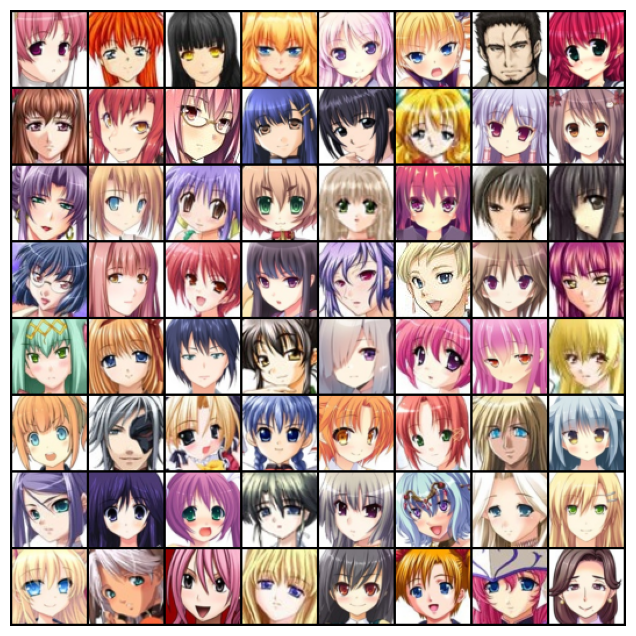

In [11]:
show_batch(train_dl)

## Using a GPU



In [12]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [13]:
device = get_default_device()
device

device(type='cuda')

In [14]:
train_dl = DeviceDataLoader(train_dl, device)

## Discriminator Network



In [15]:
import torch.nn as nn

In [16]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [17]:
discriminator = to_device(discriminator, device)

## Generator Network



In [18]:
latent_size = 128

In [19]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

In [20]:
xb = torch.randn(batch_size, latent_size, 1, 1)
print(xb.shape)

torch.Size([128, 128, 1, 1])


torch.Size([128, 3, 64, 64])


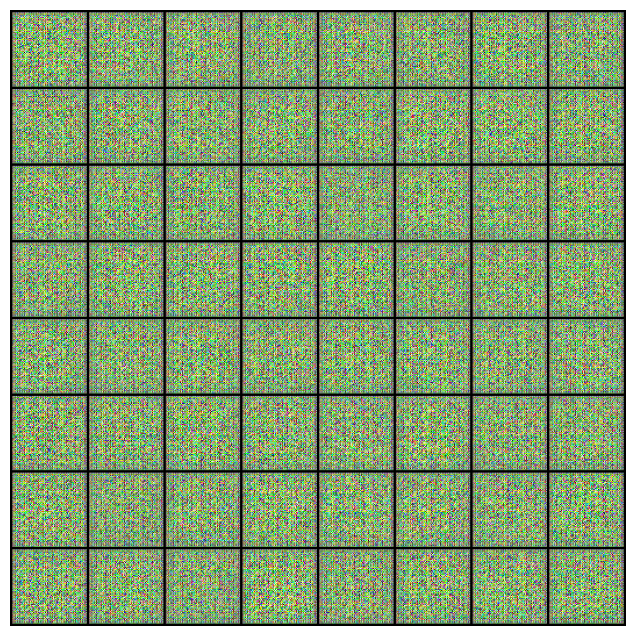

In [21]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [22]:
generator = to_device(generator, device)

## Discriminator Training



In [23]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    # print(real_targets)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()

    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    # print(real_targets)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

## Generator Training



In [24]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()

    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)

    # Update generator weights
    loss.backward()
    opt_g.step()

    return loss.item()

In [25]:
from torchvision.utils import save_image

In [26]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [27]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=6)
    print('Saving', fake_fname)
    if show:
        plt.figure(figsize=(8, 8))
        plt.axis('off')
        plt.imshow(make_grid(denorm(fake_images.cpu().detach()), nrow=6).permute(1, 2, 0))

In [28]:
fixed_latent = torch.randn(36, latent_size, 1, 1, device=device)

Saving generated-images-0000.png


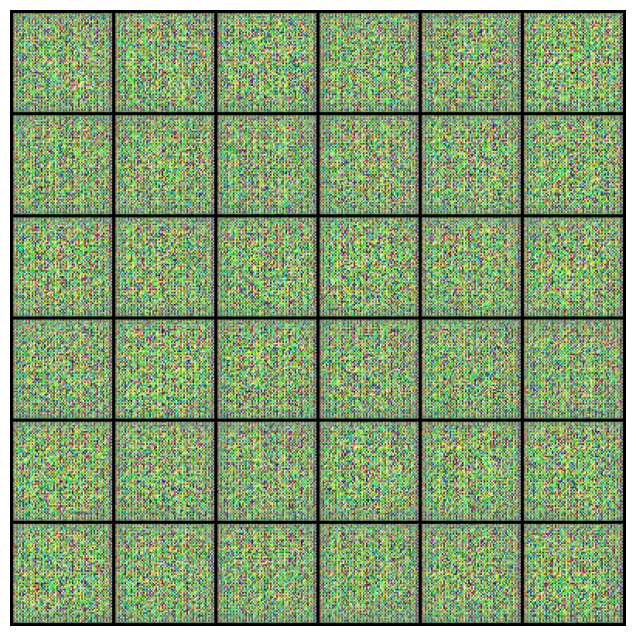

In [29]:
save_samples(0, fixed_latent)

## Full Training Loop



In [30]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [31]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()

    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)

        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)

        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))

        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)

    return losses_g, losses_d, real_scores, fake_scores

In [32]:
lr = 0.0002
epochs = 25

In [33]:
history = fit(epochs, lr)

  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [1/25], loss_g: 5.9228, loss_d: 0.4923, real_score: 0.9336, fake_score: 0.3172
Saving generated-images-0001.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [2/25], loss_g: 9.8326, loss_d: 0.7780, real_score: 0.9886, fake_score: 0.4921
Saving generated-images-0002.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [3/25], loss_g: 6.1971, loss_d: 0.1067, real_score: 0.9391, fake_score: 0.0369
Saving generated-images-0003.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [4/25], loss_g: 5.3905, loss_d: 0.1358, real_score: 0.9168, fake_score: 0.0408
Saving generated-images-0004.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [5/25], loss_g: 6.1059, loss_d: 0.1981, real_score: 0.8584, fake_score: 0.0043
Saving generated-images-0005.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [6/25], loss_g: 6.3423, loss_d: 0.0849, real_score: 0.9491, fake_score: 0.0192
Saving generated-images-0006.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [7/25], loss_g: 7.3213, loss_d: 0.0759, real_score: 0.9879, fake_score: 0.0594
Saving generated-images-0007.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [8/25], loss_g: 5.8853, loss_d: 0.0880, real_score: 0.9469, fake_score: 0.0234
Saving generated-images-0008.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [9/25], loss_g: 11.8041, loss_d: 0.1280, real_score: 0.9079, fake_score: 0.0002
Saving generated-images-0009.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [10/25], loss_g: 8.0710, loss_d: 0.0841, real_score: 0.9979, fake_score: 0.0756
Saving generated-images-0010.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [11/25], loss_g: 8.3187, loss_d: 0.1097, real_score: 0.9804, fake_score: 0.0819
Saving generated-images-0011.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [12/25], loss_g: 7.3232, loss_d: 0.0305, real_score: 0.9772, fake_score: 0.0041
Saving generated-images-0012.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [13/25], loss_g: 6.7406, loss_d: 0.0866, real_score: 0.9485, fake_score: 0.0011
Saving generated-images-0013.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [14/25], loss_g: 5.5585, loss_d: 0.0732, real_score: 0.9537, fake_score: 0.0119
Saving generated-images-0014.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [15/25], loss_g: 13.2615, loss_d: 0.2165, real_score: 0.9753, fake_score: 0.1617
Saving generated-images-0015.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [16/25], loss_g: 6.1002, loss_d: 0.0373, real_score: 0.9739, fake_score: 0.0080
Saving generated-images-0016.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [17/25], loss_g: 8.2948, loss_d: 0.1507, real_score: 0.9513, fake_score: 0.0821
Saving generated-images-0017.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [18/25], loss_g: 6.3732, loss_d: 0.0391, real_score: 0.9840, fake_score: 0.0204
Saving generated-images-0018.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [19/25], loss_g: 9.3079, loss_d: 0.0072, real_score: 0.9933, fake_score: 0.0002
Saving generated-images-0019.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [20/25], loss_g: 8.2463, loss_d: 0.0061, real_score: 0.9960, fake_score: 0.0020
Saving generated-images-0020.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [21/25], loss_g: 5.8395, loss_d: 0.2530, real_score: 0.8427, fake_score: 0.0038
Saving generated-images-0021.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [22/25], loss_g: 8.3261, loss_d: 0.1896, real_score: 0.9483, fake_score: 0.0956
Saving generated-images-0022.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [23/25], loss_g: 29.2317, loss_d: 2.7009, real_score: 0.9980, fake_score: 0.6255
Saving generated-images-0023.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [24/25], loss_g: 7.1709, loss_d: 0.0313, real_score: 0.9869, fake_score: 0.0172
Saving generated-images-0024.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [25/25], loss_g: 16.7009, loss_d: 0.0051, real_score: 0.9952, fake_score: 0.0000
Saving generated-images-0025.png


In [34]:
losses_g, losses_d, real_scores, fake_scores = history

Now that we have trained the models, we can save checkpoints.

In [35]:
# Save the model checkpoints
torch.save(generator.state_dict(), 'G.pth')
torch.save(discriminator.state_dict(), 'D.pth')

Here's how the generated images look, after the 1st, 5th and 10th epochs of training.

In [36]:
from IPython.display import Image

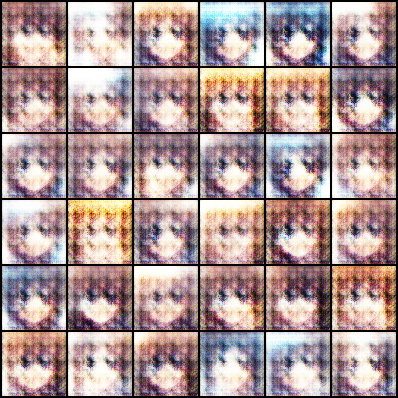

In [37]:
Image('./generated/generated-images-0001.png')

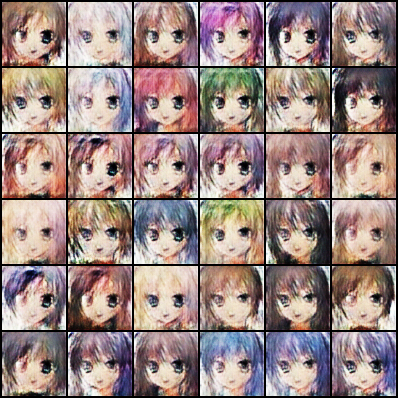

In [38]:
Image('./generated/generated-images-0005.png')

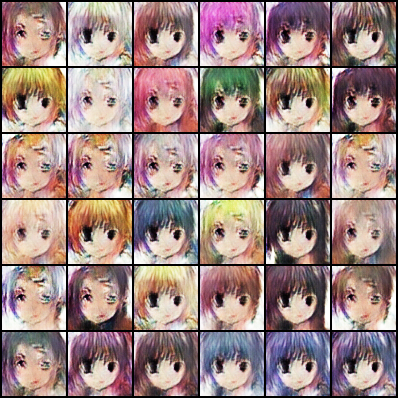

In [39]:
Image('./generated/generated-images-0010.png')

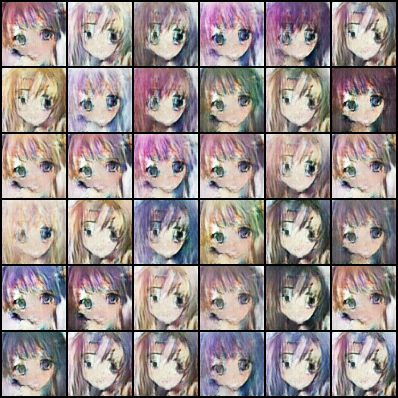

In [40]:
Image('./generated/generated-images-0020.png')

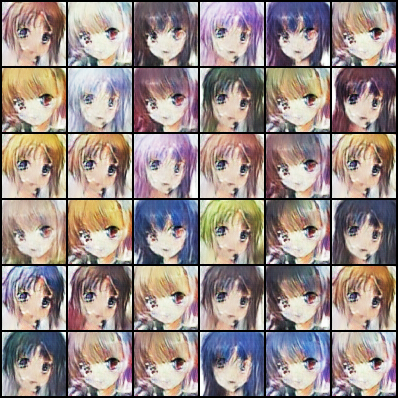

In [41]:
Image('./generated/generated-images-0025.png')

In [42]:
import cv2
import os

vid_fname = 'gans_training.mp4'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 1, (530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()

In [43]:
from IPython.display import HTML
from base64 import b64encode
mp4 = open('gans_training.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()

In [44]:
HTML("""
<video controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

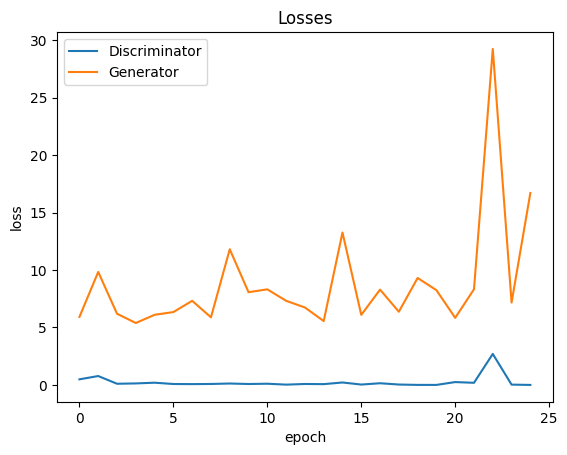

In [46]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

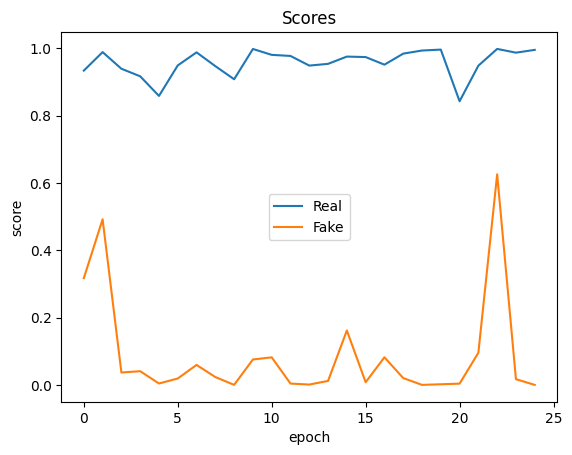

In [47]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');

###GAN using Tensorflow

In [48]:
!pip install imageio
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-fh3t0f5u
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /tmp/pip-req-build-fh3t0f5u
  Resolved https://github.com/tensorflow/docs to commit 15e96c3ee154d7c10ec9bb807ef44b4e6f08e65b
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-docs: filename=tensorflow_docs-2024.10.14.18741-py3-none-any.whl size=182607 sha256=335b4da7986f4b485e009a883167e6013c1ceb5010e4a418a2f708f79fa4e41f
  Stored in directory: /tmp/pip-ephem-wheel-cache-dcaoop55/wheels/86/0f/1e/3b62293c8ffd0fd5a49508e6871cdb7554abe9c62afd35ec53
Successfully built tensorflow-docs


In [49]:
import tensorflow as tf

In [50]:
import numpy as np
import glob
import imageio
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import  Conv2D, BatchNormalization, MaxPool2D, Dropout, Reshape, Conv2DTranspose, Dense, Activation, Flatten
from keras.metrics import BinaryCrossentropy
from keras.layers import LeakyReLU, ReLU
from tensorflow.keras.optimizers import Adam
import time


In [51]:
batch_size =128
data = keras.utils.image_dataset_from_directory(
    directory=DATA_DIR,
    label_mode=None,
    batch_size=batch_size,
    image_size=(64,64))

Found 63565 files.


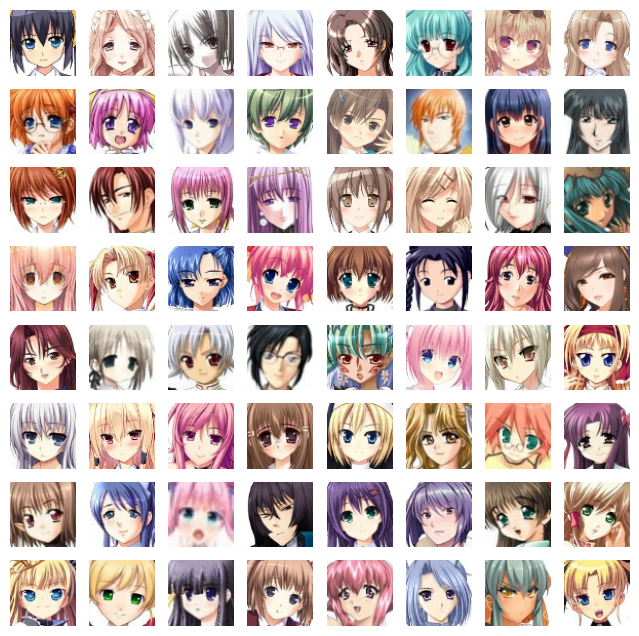

In [52]:
for images in data.take(1):
  plt.figure(figsize=(8,8))
  for i in range(64):
    plt.subplot(8,8,i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.axis('off')

In [53]:
data = data.map(lambda d: (d-127.5)/127.5)

In [54]:
def Discriminator():
  model = Sequential([
      Conv2D( filters=64, kernel_size=3, strides=(2,2), padding="same",  input_shape=(64,64,3)),
      BatchNormalization(),
      LeakyReLU(),
      Dropout(0.2),
      Conv2D( filters=128, kernel_size=3, strides=(2,2), padding="same",  input_shape=(64,64,3)),
      BatchNormalization(),
      LeakyReLU(),
      Dropout(0.2),
      Conv2D( filters=256, kernel_size=3, strides=(2,2), padding="same",  input_shape=(64,64,3)),
      BatchNormalization(),
      LeakyReLU(),
      Dropout(0.2),
      Conv2D( filters=516, kernel_size=3, strides=(2,2), padding="same",  input_shape=(64,64,3)),
      BatchNormalization(),
      LeakyReLU(),
      Dropout(0.2),
      Flatten(),
      Dense(1024),
      LeakyReLU(),
      Dense(1, activation="sigmoid")
  ])
  return model


In [55]:
model_d = Discriminator()
model_d.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 32, 32, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 8, 8, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 8, 8, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 4, 4, 516)           │       1,189,380 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 4, 4, 516)           │           2,064 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 4, 4, 516)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 4, 4, 516)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 8256)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │       8,455,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 10,020,245 (38.22 MB)

 Trainable params: 10,018,317 (38.22 MB)

 Non-trainable params: 1,928 (7.53 KB)

In [79]:
def Generator():
  model = Sequential([
    Dense(4*4*256, use_bias=False, input_shape=(128,)), # latent_dim = 128
    BatchNormalization(),
    ReLU(),

    Reshape((4, 4, 256)),
    BatchNormalization(),

    Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', use_bias=False),
    BatchNormalization(),
    ReLU(),

    Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', use_bias=False),
    BatchNormalization(),
    ReLU(),

    Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same', use_bias=False, activation='tanh'),
    BatchNormalization(),
    ReLU(),

    Conv2DTranspose(3, (3, 3), strides=(2, 2), padding='same', use_bias=False, activation='tanh'),
    BatchNormalization(),
    ReLU(),
    ])
  return model


In [57]:
model_g = Generator()
model_g.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                      │ (None, 4096)                │         524,288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 4096)                │          16,384 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu (ReLU)                         │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 4, 4, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 8, 8, 128)           │         294,912 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_1 (ReLU)                       │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 16, 16, 64)          │          73,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_2 (ReLU)                       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 32, 32, 32)          │          18,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_3 (ReLU)                       │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_3 (Conv2DTranspose) │ (None, 64, 64, 3)           │             864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 64, 64, 3)           │              12 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_4 (ReLU)                       │ (None, 64, 64, 3)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 930,540 (3.55 MB)

 Trainable params: 921,382 (3.51 MB)

 Non-trainable params: 9,158 (35.77 KB)

In [80]:
# check random sample
sample = tf.random.normal([32,128])
out = model_g(sample, training =False)

In [81]:
out.shape

TensorShape([32, 64, 64, 3])

(-0.5, 63.5, 63.5, -0.5)

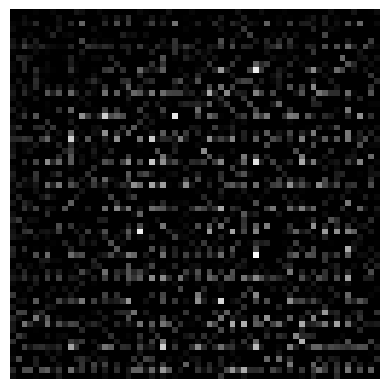

In [82]:
plt.imshow(out[0, :, :, 0], cmap='gray')
plt.axis("off")

In [61]:
# generator output to the discriminator
pred = model_d(out, training=False)
print(pred)

tf.Tensor([[0.5000957]], shape=(1, 1), dtype=float32)


In [62]:
cross_entropy = BinaryCrossentropy(from_logits=True)
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [63]:
g_optim = Adam(1e-4)
d_optim= Adam(1e-4)

In [64]:
# checkpoint
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=g_optim,
                                 discriminator_optimizer=d_optim,
                                 generator=model_g,
                                 discriminator=model_d)

In [65]:
sample = tf.random.normal([16, 128])

In [66]:
BATCH_SIZE = 128
latent_dim = 128

In [75]:
@tf.function
def training_step(images):
    noise = tf.random.normal([BATCH_SIZE, latent_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise)

      real_output = discriminator(images)
      fake_output = discriminator(generated_images)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)


    gradients_g = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_d = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    g_optim.apply_gradients(zip(gradients_g, generator.trainable_variables))
    d_optim.apply_gradients(zip(gradients_d, discriminator.trainable_variables))
    return gen_loss, disc_loss

In [68]:
# save & show image
save_dir = 'flow_generated'
os.makedirs(save_dir, exist_ok=True)

In [69]:
def show_images(epoch, seed):
  gen_images = model_g(seed)
  plt.figure(figsize=(8,8))
  for i in range(gen_images[0]):
    plt.subplot(16,16,i+1)
    plt.imshow(gen_images[i,:,:,:]*127.5 + 127.5)
    plt.axis('off')
  plt.savefig(os.path.join(save_dir,'generated_at_epoch_{:04d}.png'.format(epoch)) )
  plt.show()




In [73]:
def fit(epochs, dataset, seed):
  torch.cuda.empty_cache()
  # Losses & scores
  losses_g = []
  losses_d = []
  for i in range(epochs):
    for batch in dataset:
      g_loss, d_loss = training_step(batch)
      losses_g.append(g_loss)
      losses_d.append(d_loss)

      display.clear_output(wait=True)
      show_images( i + 1,seed)

      if (i + 1) % 15 == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)

  display.clear_output(wait=True)
  show_images( epochs,seed)
  return losses_g, losses_d


In [ ]:
history = fit(25, data, sample)

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [ ]:
from IPython.display import Image

In [ ]:
Image("./flow_generated/generated_at_epoch_0010.png")

In [ ]:
anim_file = 'anime.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('generated*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

In [ ]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)